# Implement Value at Risk & Conditional Value at Risk using:

    1. Historical Method
    2. Parametric Method (Variance-Covariance)
    3. Monte Carlo Method

## Get the Historical Data
First let's import the dependencies and get the data! We also assign random weightings to the given stock portfoio. Please feel free to change these weightings to whatever allocation you'd like!

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
from scipy.stats import norm, t
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use('ggplot')

In [2]:
# Import data
def getData(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

stocks = ['NVDA', 'GOOGL', 'TSLA', 'BAC', 'PLTR', 'PFE', 'MSTR', 'F', 'SMCI', 'MRO']
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800)

returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
returns = returns.dropna()

weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)

returns['portfolio'] = returns.dot(weights)

[*********************100%***********************]  10 of 10 completed


## Historical VaR

Here we make no assumptions about the distribution of returns.

In [12]:
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

# 100 days
Time = 100

hVaR = -historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
hCVaR = -historicalCVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)

InitialInvestment = 10000
print('Expected Portfolio Return     :      ', round(InitialInvestment*pRet,2))
print('Historical VaR 95th CI        :      ', round(InitialInvestment*hVaR,2))
print('Historical CVaR 95th CI       :      ', round(InitialInvestment*hCVaR,2))

Expected Portfolio Return     :       2180.12
Historical VaR 95th CI        :       2763.78
Historical CVaR 95th CI       :       3728.97


## Parametric VaR

Here we make an assumption on the distribution of returns abd use the historical portfolio returns and standard deviations (estimates) to define parameters for the model. Here we have implemented two parametric VaR models:
 - normal distribution
 - t-distribution (fatter tails)

In [4]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print("Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print("t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print("t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))

Normal VaR 95th CI       :       938.42
Normal CVaR 95th CI      :       1730.65
t-dist VaR 95th CI       :       827.97
t-dist CVaR 95th CI      :       1907.84


## Monte Carlo VaR & CVaR

In this section we use a Monte Carlo simulation of a stock portfolio and then use the functions for historical VaR and CVaR to calculate our risk parameters.

The main advantage here is we could define individual models/stock dynamics for individual assets. This can be very powerful!

In [5]:
# Monte Carlo Method
mc_sims = 500 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

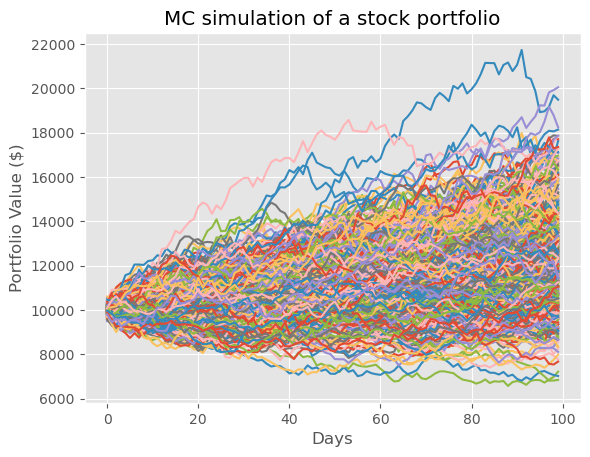

In [6]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [7]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [13]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('MC VaR  95th CI      :      ', round(VaR,2))
print('MC CVaR 95th CI      :      ', round(CVaR,2))

MC VaR  95th CI      :       917.23
MC CVaR 95th CI      :       1593.25


## Comparison of each VaR & CVaR methods

In [9]:
print("\nVaR:")

print(' historical VaR 95th CI   :      ', round(InitialInvestment*hVaR,2))
print(" Normal VaR 95th CI       :      ", round(InitialInvestment*normVaR,2))
print(" t-dist VaR 95th CI       :      ", round(InitialInvestment*tVaR,2))
print(" MC VaR  95th CI          :      ", round(VaR,2))


print("\nCVaR:")

print(' historical CVaR 95th CI  :      ', round(InitialInvestment*hCVaR,2))
print(" Normal CVaR 95th CI      :      ", round(InitialInvestment*normCVaR,2))
print(" t-dist CVaR 95th CI      :      ", round(InitialInvestment*tCVaR,2))
print(" MC CVaR 95th CI          :      ", round(CVaR,2))


VaR:
 historical VaR 95th CI   :       2763.78
 Normal VaR 95th CI       :       938.42
 t-dist VaR 95th CI       :       827.97
 MC VaR  95th CI          :       917.23

CVaR:
 historical CVaR 95th CI  :       3728.97
 Normal CVaR 95th CI      :       1730.65
 t-dist CVaR 95th CI      :       1907.84
 MC CVaR 95th CI          :       1593.25
